In [1]:
import torch, time, pickle, os, sys, argparse
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp

 #############################################################################
 ## This is the new version that takes merger, early and premerger halos, ####
 #############################################################################

def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))
# m_star, v_disk, m_cold in disk, m_cold (HI), m_cold (H2), Z_star, SFR instantaneous, SFR_100
zcut=0
tcols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,23,24,25,35]+list(range(37,60)))
target=np.arange(41)
lim=10
case='test'
save = False
transform=None
maxs=[1,1,1]
i,j,k=0,0,0

dat=[]
tcols=np.array(tcols)
raw_path=osp.expanduser('~/../../../tigress/cj1223/merger_trees/isotrees/')
target_path=osp.expanduser('~/../../../tigress/cj1223/merger_trees/samout/')
if transform:
    transform_path=osp.expanduser(f"~/../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl")
    scaler=pickle.load(open(transform_path, 'rb'))
not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0]) #should be included in loading?
is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
    0,0,0,0,0,0,0,0,0,0,0] #is it a categorical variable?
is_cat=np.array([bool(i) for i in is_cat])
icols=np.array([1,3]) #idcolumns
load_cols=np.sort(np.concatenate([tcols,icols]))
not_include=not_include[load_cols]
meta={'tcols':tcols,
     'transform':transform,
     'target': target,
     'maxs':maxs}
extrastot=[]
fails = 0
long = 0


In [2]:
start=time.time()
print(f'Loading isotree {i}_{j}_{k}')
pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
print(f'isotree {i}_{j}_{k} loaded, restructuring')

raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
del pd1

trees=raw[raw.isna()['desc_id(3)']] 
halos=raw[~raw.isna()['desc_id(3)']]
del raw

##########################################
### End loading, begin dtype changing  ###
##########################################

mask=halos.dtypes.values[1:]=='O'

f,it="float64", "int64"
map1=[]
map2=[]
q=0
for l in load_cols:
    q+=1
    if l<25:
        map1.append(l)
        map2.append(q)
map1=np.array(map1)
map2=np.array(map2)

castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

castto=castto[map1]
dicts = {}
keys = halos.columns[map2]
for d, key in enumerate(keys):
        dicts[key] = castto[d]

halos=halos.astype(dicts)

###################################################
### end dtype, z-selection                      ###
###################################################



mask=(1/halos['#scale(0)']-1)>=zcut
zhalos=halos[mask]
acut_true=np.unique(zhalos['#scale(0)'])[-1]
zcut_true=1/acut_true-1
zhalos['desc_id(3)'][zhalos['#scale(0)']==acut_true]=-1
meta['zcut']=[zcut,zcut_true]

del halos

#########################################################
### end z-selcetion, begin inital hardcoded scaling   ###
#########################################################


log = [10,38, 39, 40, 41, 42, 57, 58]
#simple log for the rest
def logt(x):
    return np.log10(x+1)
for l in log:
    if l in tcols:
        l1=np.where(load_cols==l)[0][0]+1
        zhalos[zhalos.columns[l1]]=logt(zhalos[zhalos.columns[l1]])

minmax = [23,24,25]
#simple min/max for 1e13 scaling down
def maxscale(x):
    return x/max(x)
for l in minmax:
    if l in tcols:
        l1=np.where(load_cols==l)[0][0]+1
        zhalos[zhalos.columns[l1]]=maxscale(zhalos[zhalos.columns[l1]])

scale_cols=np.array(tcols[~is_cat[tcols]])
meta['scale_cols']=scale_cols

#########################################################
### end inital hardcoded scaling, begin split/scale   ###
#########################################################

indices = [i for i, x in enumerate(zhalos['desc_id(3)']) if x == -1]
print(f'Splitting to tree and scaling')
spli=np.split(np.array(zhalos)[:,1:], np.array(indices[1:]))
# del zhalos, halos
splits=[]
for s in spli:
    if s[0,np.where(load_cols==10)[0][0]]>lim: # select massive halos
        splits.append(s)
splits=np.array(splits, dtype=object)
split=[]
for tree in splits:
    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)] # things that either are the final halo, or has more than one progenitor (mergers) or zero progenitors (roots)
    if transform:
        for n in scale_cols:
            n1=np.where(load_cols==n)[0][0]
            s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1])) #scale if transform, not the best implementation
    split.append(s)
split=np.array(split, dtype=object)
print('Split done')

#########################################################
### end split, begin target loading                   ###
#########################################################

# del zhalos



Loading isotree 0_0_0


/tmp/ipykernel_14298/1024709390.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)


isotree 0_0_0 loaded, restructuring


/tmp/ipykernel_14298/1024709390.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zhalos['desc_id(3)'][zhalos['#scale(0)']==acut_true]=-1


Splitting to tree and scaling
Split done


In [6]:
zhalos.columns

Index(['index', '#scale(0)', 'id(1)', 'desc_scale(2)', 'desc_id(3)',
       'num_prog(4)', 'pid(5)', 'upid(6)', 'desc_pid(7)', 'phantom(8)',
       'Mvir(10)', 'Rvir(11)', 'rs(12)', 'vrms(13)', 'mmp?(14)',
       'scale_of_last_MM(15)', 'vmax(16)', 'Jx(23)', 'Jy(24)', 'Jz(25)',
       'Tidal_Force(35)', 'Rs_Klypin', 'Mvir_all', 'M200b', 'M200c', 'M500c',
       'M2500c', 'Xoff', 'Voff', 'Spin_Bullock', 'b_to_a', 'c_to_a', 'A[x]',
       'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)',
       'A[y](500c)', 'A[z](500c)', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer',
       'Halfmass_Radius'],
      dtype='object')

In [7]:
print('Loading targets')
ex=f'{i}_{j}_{k}/galprop_0-99.dat'
pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
newcols=pdc.iloc[:,0]
pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
pds.columns=np.array(newcols)

#########################################################
### end target loading, begin z-cut                   ###
#########################################################

zcut_SAM=np.unique(pds[pds.columns[3]])[np.isclose(np.unique(pds[pds.columns[3]]),zcut_true)][0] #find the redshift closest to the desired redshift
pdz=pds[pds[pds.columns[3]]==zcut_SAM] # redshift selection for selecting final halos
pdcen=pdz[(pdz[pds.columns[4]]==0)] ##central haloes

# del pdz

rhalid=np.array(pdcen[pds.columns[1]])

Loading targets


In [8]:
pdcen

,# 0 halo_index (long),# 1 birthhaloid (long long),# 2 roothaloid (long long),# 3 redshift,# 4 sat_type 0= central,# 5 mhalo total halo mass [1.0E09 Msun],# 6 m_strip stripped mass [1.0E09 Msun],# 7 rhalo halo virial radius [Mpc)],# 8 mstar stellar mass [1.0E09 Msun],# 9 mbulge stellar mass of bulge [1.0E09 Msun],...,# 31 tmajmerge time since last major merger [Gyr],# 32 mu_merge mass ratio of last merger [],# 33 t_sat time since galaxy became a satellite in this halo [Gyr],# 34 r_fric distance from halo center [Mpc],# 35 x_position x coordinate [cMpc],# 36 y_position y coordinate [cMpc],# 37 z_position z coordinate [cMpc],# 38 vx x component of velocity [km/s],# 39 vy y component of velocity [km/s],# 40 vz z component of velocity [km/s]
74,91,1122969408,1122969408,0.0,0,0.894597,0.894597,0.025384,1.918680e-05,1.705140e-06,...,11.09850,0.252340,-99.0,0.0,16.56910,0.719250,11.5074,554.13,-153.42,-43.49
155,210,1122969424,1122969424,0.0,0,1.815770,1.815770,0.032140,5.311550e-04,9.893530e-05,...,12.59660,0.633187,-99.0,0.0,16.27690,0.460703,11.3982,313.90,-11.27,-0.41
252,348,1122969427,1122969427,0.0,0,4.880430,4.880430,0.044686,1.461610e-03,2.745250e-04,...,9.52878,0.322417,-99.0,0.0,16.38050,0.550576,11.1197,262.94,73.92,3.79
317,508,1122969444,1122969444,0.0,0,1.860050,1.860050,0.032399,5.375590e-06,2.401990e-06,...,9.21375,0.368127,-99.0,0.0,16.24820,0.582477,11.5503,276.20,346.07,160.42
387,613,1122969460,1122969460,0.0,0,1.615000,1.615000,0.030908,1.164560e-05,0.000000e+00,...,113.70200,0.000000,-99.0,0.0,16.85540,0.500886,11.5264,492.17,366.10,122.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060248,2651924,1123258115,1123258115,0.0,0,0.977266,0.977266,0.026143,0.000000e+00,0.000000e+00,...,5.65649,0.577821,-99.0,0.0,7.49097,9.163450,21.3496,194.70,182.78,222.33
1060309,2652030,1123259834,1123259834,0.0,0,1.092410,1.092410,0.027132,8.983740e-08,9.696510e-14,...,8.90917,0.272320,-99.0,0.0,9.01060,18.930500,18.1481,155.43,288.65,199.44
1060370,2652118,1123260418,1123260418,0.0,0,0.900502,0.900502,0.025440,4.428310e-06,0.000000e+00,...,113.70200,0.000000,-99.0,0.0,13.19550,21.070000,17.4129,69.85,90.30,270.94
1060418,2652205,1123261316,1123261316,0.0,0,0.894597,0.894597,0.025384,0.000000e+00,0.000000e+00,...,113.70200,0.000000,-99.0,0.0,7.30819,7.406450,17.7398,224.54,157.57,191.28


In [10]:
halid = []
mdm = []
for s in split:
    halid.append(s[0,1])
    mdm.append(s[0,10])
    
halid=np.array(halid)

In [11]:
# v_disk=pdcen[pdcen[pdcen.columns[5]]>10][pdcen.columns[11]]
# pdmcen=pdcen[pdcen[pdcen.columns[5]]>10]
# v_disk

In [12]:
halwgal=[] ##scaled
ids=[]
out=[]
ms = []
Mh = []
indexs = []
for idx, tree in enumerate(split): #split up into tree
    if tree[0,1] in rhalid:
        if len(tree)>20000:
            print(len(tree))
            long+=1
        else:
            halwgal.append(tree) ##scaled
            ids.append(idx)
            index=np.where(rhalid==tree[0,1])
            out.append(np.array(pdcen.iloc[index])[0][11]) ## target variable column
            ms.append(np.array(pdcen.iloc[index])[0][5])
            indexs.append(index[0][0])
            Mh.append(tree[0,10])
hraw=np.array(splits[ids], dtype=object) ##unscaled


# del pdcen
# del pds


In [13]:
pdi=pdcen.iloc[indexs]

In [14]:
pdi[pdcen.columns[1]]==pdi[pdcen.columns[2]] #there's 1 where it isn't true

3498      True
5694      True
6561      True
7021      True
8662      True
          ... 
866785    True
866874    True
867500    True
868897    True
869218    True
Length: 770, dtype: bool

In [15]:
vmax = []
for hal in halwgal:
    vmax.append(hal[0,15])
vmax=np.array(vmax)
out=np.array(out)
ms=np.array(ms)

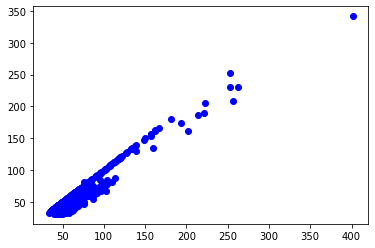

In [16]:
plt.plot(vmax,out, 'bo')

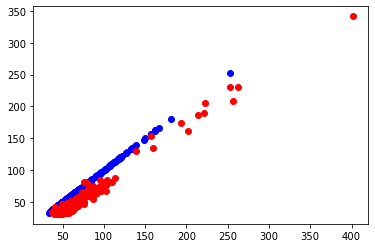

In [17]:
mask=vmax==out
plt.plot(vmax[mask], out[mask], 'bo')
plt.plot(vmax[~mask], out[~mask], 'ro')

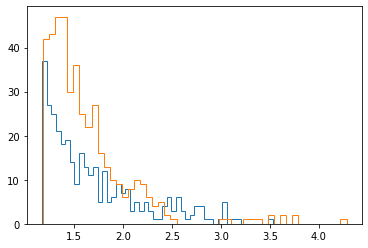

In [42]:
plt.hist(np.log10(ms[mask]), bins=50, histtype='step');
plt.hist(np.log10(ms[~mask]), bins=50, histtype='step');

(array([  1.,   2.,   6.,   7.,  15.,  29.,  54.,  98., 202., 356.]),
 array([-1.60493753, -1.39732881, -1.18972008, -0.98211136, -0.77450264,
        -0.56689392, -0.3592852 , -0.15167647,  0.05593225,  0.26354097,
         0.47114969]),
 <BarContainer object of 10 artists>)

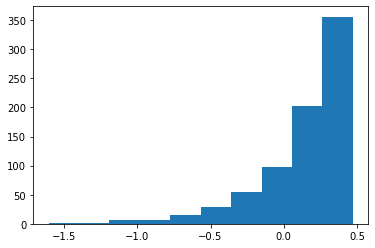

In [47]:
plt.hist(np.log10(Mh)-np.log10(ms))

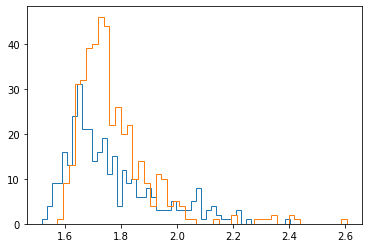

In [35]:
plt.hist(np.log10(vmax[mask]), bins=50, histtype='step');
plt.hist(np.log10(vmax[~mask]), bins=50, histtype='step');

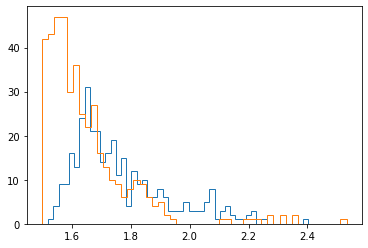

In [17]:
plt.hist(np.log10(out[mask]), bins=50, histtype='step');
plt.hist(np.log10(out[~mask]), bins=50, histtype='step');

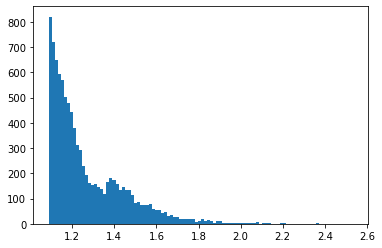

In [24]:
plt.hist(np.log10(pdcen[pdcen.columns[11]]), bins=100);

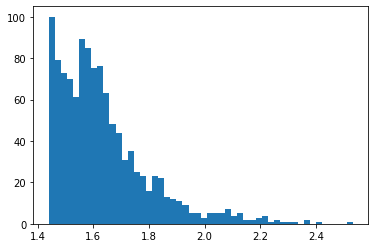

In [26]:
plt.hist(np.log10(pdmcen[pdmcen.columns[11]]), bins=50);

In [19]:
sum(mask)/len(mask)

0.44155844155844154

In [103]:
pdi[~mask][pdi.columns[:10]]

,# 0 halo_index (long),# 1 birthhaloid (long long),# 2 roothaloid (long long),# 3 redshift,# 4 sat_type 0= central,# 5 mhalo total halo mass [1.0E09 Msun],# 6 m_strip stripped mass [1.0E09 Msun],# 7 rhalo halo virial radius [Mpc)],# 8 mstar stellar mass [1.0E09 Msun],# 9 mbulge stellar mass of bulge [1.0E09 Msun]
5694,11838,1122970370,1122970370,0.0,0,128.5310,128.5310,0.132950,2.136860,0.231256
67263,229019,1122971001,1122971001,0.0,0,83.3333,83.3333,0.115069,0.326517,0.142762
112842,369075,1122982238,1122982238,0.0,0,15.3134,15.3134,0.065420,0.008342,0.001080
136237,444954,1122983707,1122983707,0.0,0,340.4190,340.4190,0.183946,0.650607,0.186021
136921,446793,1122983726,1122983726,0.0,0,88.6724,88.6724,0.117476,0.147955,0.035248
...,...,...,...,...,...,...,...,...,...,...
865714,2262729,1123203053,1123203053,0.0,0,15.0133,15.0133,0.064990,0.002417,0.000109
866378,2264008,1123203082,1123203082,0.0,0,15.2446,15.2446,0.065322,0.004768,0.000659
866785,2264954,1123203166,1123203166,0.0,0,15.5447,15.5447,0.065748,0.006150,0.001145
867500,2266607,1123203384,1123203384,0.0,0,14.9099,14.9099,0.064840,0.005464,0.000786


In [100]:
pdi[mask][pdi.columns[10:20]].describe()

,# 10 mstar_merge stars entering via mergers] [1.0E09 Msun],# 11 v_disk rotation velocity of disk [km/s],# 12 sigma_bulge velocity dispersion of bulge [km/s],# 13 r_disk exponential scale radius of stars+gas disk [kpc],# 14 r_bulge 3D effective radius of bulge [kpc],# 15 mcold cold gas mass in disk [1.0E09 Msun],# 16 mHI cold gas mass [1.0E09 Msun],# 17 mH2 cold gas mass [1.0E09 Msun],# 18 mHII cold gas mass [1.0E09 Msun],# 19 Metal_star metal mass in stars [Zsun*Msun]
count,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000,430.000000
mean,0.788438,47.983548,59.086541,2.260315,0.343659,0.823210,0.283187,0.022560,0.303929,2.853171
std,10.852459,29.038171,51.542203,2.644509,1.023519,2.018013,0.602236,0.093466,0.940490,35.457653
min,0.000003,31.485100,24.252400,0.922097,0.000005,0.000000,0.000000,0.000000,0.000000,0.000038
25%,0.000323,35.473325,33.268900,1.281452,0.006537,0.218827,0.075547,0.000740,0.079348,0.000282
50%,0.001107,40.404650,41.599300,1.698575,0.040171,0.355391,0.132220,0.001951,0.129429,0.000837
75%,0.004023,49.039750,59.891875,2.474502,0.232042,0.652667,0.258163,0.007416,0.233988,0.005044
max,221.277000,341.555000,573.093000,33.080100,13.992600,23.106600,6.273680,0.987434,11.996400,710.648000


In [93]:
pdi[~mask].describe()

,# 0 halo_index (long),# 1 birthhaloid (long long),# 2 roothaloid (long long),# 3 redshift,# 4 sat_type 0= central,# 5 mhalo total halo mass [1.0E09 Msun],# 6 m_strip stripped mass [1.0E09 Msun],# 7 rhalo halo virial radius [Mpc)],# 8 mstar stellar mass [1.0E09 Msun],# 9 mbulge stellar mass of bulge [1.0E09 Msun],...,# 31 tmajmerge time since last major merger [Gyr],# 32 mu_merge mass ratio of last merger [],# 33 t_sat time since galaxy became a satellite in this halo [Gyr],# 34 r_fric distance from halo center [Mpc],# 35 x_position x coordinate [cMpc],# 36 y_position y coordinate [cMpc],# 37 z_position z coordinate [cMpc],# 38 vx x component of velocity [km/s],# 39 vy y component of velocity [km/s],# 40 vz z component of velocity [km/s]
count,3.400000e+02,3.400000e+02,3.400000e+02,340.0,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,...,340.000000,340.000000,340.0,340.0,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,1.490869e+06,1.123096e+09,1.123096e+09,0.0,0.0,121.469634,121.469634,0.105016,2.532307,0.320749,...,64.749215,0.194123,-99.0,0.0,12.503586,10.790665,12.768106,224.741029,72.580824,154.165765
std,6.368912e+05,9.733206e+04,9.733207e+04,0.0,0.0,275.107136,275.107136,0.050283,12.302853,1.384305,...,52.043677,0.109565,0.0,0.0,5.593768,6.279350,5.915662,91.459570,113.876178,93.214929
min,1.183800e+04,1.122970e+09,1.122970e+09,0.0,0.0,14.821400,14.821400,0.064712,0.000518,0.000043,...,0.998451,0.000000,-99.0,0.0,0.123206,0.045350,0.050162,-27.600000,-254.720000,-248.730000
25%,9.320692e+05,1.123003e+09,1.123003e+09,0.0,0.0,20.019950,20.019950,0.071533,0.008409,0.001406,...,10.940025,0.124870,-99.0,0.0,8.340955,5.797535,8.420253,168.820000,-11.322500,107.730000
50%,1.058602e+06,1.123008e+09,1.123008e+09,0.0,0.0,35.186000,35.186000,0.086326,0.024921,0.004728,...,113.702000,0.171229,-99.0,0.0,13.243850,10.841750,13.665150,224.825000,69.990000,160.655000
75%,2.165058e+06,1.123198e+09,1.123198e+09,0.0,0.0,88.487825,88.487825,0.117394,0.159576,0.030626,...,113.702000,0.236992,-99.0,0.0,16.810375,16.040725,17.438225,281.275000,161.487500,211.912500
max,2.270349e+06,1.123204e+09,1.123204e+09,0.0,0.0,3401.240000,3401.240000,0.396186,136.518000,15.279200,...,113.702000,0.861360,-99.0,0.0,22.060900,22.135300,22.116900,512.800000,392.950000,425.880000


In [ ]:
hraw=np.array(splits[ids], dtype=object)
hals=[]
pr,de=[],[]
discards=[]
extras=[]
print('Making merger tree')
for n in tqdm(range(len(halwgal))):
# for n in tqdm(range(8)):
    halmix = []
    h=halwgal[n]
    roots=h[h[:,4]==0]
    mergers=h[h[:,4]>1]
    final=h[h[:,3]==-1]
    pro, des=[],[]
    discarded=[]
    premerger_id=[]
    finalid=final[0][1]
    for q, mid in enumerate(mergers[:,1]):
        halmix.append(mergers[q]) ## add progenitor
        k=1
        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
        while descid not in mergers[:,1] and descid!=-1: 
            proid=hraw[n][:,1][np.where(descid==hraw[n][:,1])]
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])] ##new descendant id where current descendant id = halo id
            k+=1
        pro.append(mid)
        if k>1 and proid!=finalid: #only if relevant
            premerger_id.append(proid)
            halmix.append(hraw[n][np.where(proid==hraw[n][:,1])]) ### add halo before merger
            discarded.append(1)
            des.append(proid)
            pro.append(proid)
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
#             halmix.append(hraw[n][np.where(descid==hraw[n][:,1])])
        discarded.append(1/k) 

    for r in roots:
        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
        halmix.append(r)
        k=1
        while descid not in mergers[:,1] and descid!=[-1]: 
            proid=hraw[n][:,1][np.where(descid==hraw[n][:,1])] 
            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
            k+=1

        pro.append(r[1]) 
        if k>1 and proid!=finalid: #only if relevant
            premerger_id.append(proid)
            halmix.append(hraw[n][np.where(proid==hraw[n][:,1])])
            discarded.append(1)
            des.append(proid)
            pro.append(proid)
        if descid!=-1:
            des.append(descid[0])
        else:
            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
        discarded.append(1/k) 
    discards.append(np.array(discarded))
    des,pro=convert(des, pro)
    hal2=np.vstack([final,np.vstack(halmix)])
    if n==0:
        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward in data
        idcols=[i for i in range(len(hal2[0])) if not_include[i]==1] ##choose id cols to carry forward in meta
    extra=hal2[:,np.array(idcols)[np.array([0,1])]]
    extras.append(extra)
    hal2=hal2[:,fcols] ##take away id's
    hals.append(hal2)
    pr.append([int(p) for p in pro])
    de.append([int(d) for d in des])
extrastot.append(np.array(extras, dtype=object))
hals=np.array(hals,dtype=object)
out=np.array(out)

## I'll do this manually later


# outtrans=[]
# for n in range(len(out)):
#     outs=[]
#     for w in range(len(out[0])):
#         pl=np.log10(out[n,w])
#         if pl == -np.inf:
#             fails+=1
#             if w==2:
#                 outs.append(-0.21)
#             if w==3:
#                 outs.append(-2.507)

#             print('failed', w, n, len(hals[n]))
#         else:
#             outs.append(np.log10(out[n,w]))
#     # print(np.array(outs))
#     # print(np.array(outs).shape)
#     outtrans.append(np.array(outs).T)

#     # except:
#     #     outtrans.append(np.log10(out[n,w]+1))

# out=np.array(outtrans)
# print(out)
for n in tqdm(range(len(out))):
    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
    x = torch.tensor(hals[n], dtype=torch.float)
    y=torch.tensor(out[n], dtype=torch.float)
    edge_attr=torch.tensor(discards[n], dtype=torch.float)
    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    dat.append(graph)
stop=time.time()
print(f'Done with subvolume. \n Time elapsed {stop-start} s')
meta['extra'] = np.array(extrastot, dtype=object)
meta['fails'] = fails
meta['long'] = long